# 3DMNN
#### EXPERIMENTS

In [2]:
import os.path as osp
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/home/viktorv/Projects/3DMNN/main/models/latent_space/src")

from classes.autoencoder import Configuration as Conf
from classes.gan import ConfigurationGAN as ConfGAN
from classes.pointnet_ae import PointNetAutoEncoder

from utils.templates import innofair_architecture
from utils.templates import autoencoder_paper, default_train_params
from utils.io import obj_wrapper, generate_mitsuba_xml

from utils.io import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from utils.utils import reset_tf_graph
from classes.latent_gan import LatentGAN

top_out_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data'          # Use to save Neural-Net check-points etc.
top_in_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

#class_name = input('Give me the class name (e.g. "chair"): ').lower()
class_name = "airplane"

syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir, syn_id)

all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

# train_params = default_train_params()

# encoder, decoder, enc_args, dec_args = autoencoder_paper(n_pc_points, bneck_size)


# conf = Conf(
#     n_input = [n_pc_points, 3],
#     loss = ae_loss,
#     training_epochs = 69,
#     batch_size = train_params['batch_size'],
#     denoising = train_params['denoising'],
#     learning_rate = train_params['learning_rate'],
#     train_dir = train_dir,
#     loss_display_step = train_params['loss_display_step'],
#     saver_step = train_params['saver_step'],
#     z_rotate = train_params['z_rotate'],
#     encoder = encoder,
#     decoder = decoder,
#     encoder_args = enc_args,
#     decoder_args = dec_args
# )
# conf.experiment_name = experiment_name
# conf.held_out_step = 5   # How often to evaluate/print out loss on 
#                          # held_out data (if they are provided in ae.train() ).
# conf.save(osp.join(train_dir, 'configuration'))

# reset_tf_graph()
# ae = PointNetAutoEncoder(conf.experiment_name, conf)

# buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
# fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
# train_stats = ae.train(all_pc_data, conf, log_file=fout)
# fout.close()

conf = Conf.load(train_dir + "/configuration")
conf.encoder_args['verbose'] = False
conf.decoder_args['verbose'] = False

reset_tf_graph()

ae = PointNetAutoEncoder(conf.experiment_name, conf)
ae.restore_model(conf.train_dir, 10, verbose=False)

buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

<generator object files_in_subdirs at 0x7f9a284cc360>
4045 pclouds were loaded. They belong in 1 shape-classes.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from /home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/single_class_ae/models.ckpt-10
Epoch: 0011 training time (minutes)= 0.2706 loss= 0.043360965
Epoch: 0012 training time (minutes)= 0.2528 loss= 0.039402440
Epoch: 0013 training time (minutes)= 0.2530 loss= 0.039351557
Epoch: 0014 training time (minutes)= 0.2531 loss= 0.038678695
Epoch: 0015 training time (minutes)= 0.2532 loss= 0.039132061
Epoch: 0016 training time (minutes)= 0.2534 loss= 0.038443989
Epoch: 0017 training time (minutes)= 0.2532 loss= 0.038484954
Epoch: 0018 training time (minutes)= 0.2531 loss= 0.037860367
Epoch: 0019 training time (minutes)= 0.2532 loss= 0.037640555
Epoch: 0020 training time (minutes)= 0.2532 loss= 0.037496208
INFO:tenso

Trained a simple point net auto encoder... Define reconstruct and interpolate functions

In [7]:
print(all_pc_data.point_clouds[-1].shape)

import random as rd

from_int = rd.randint(0, 4000)
to_int = rd.randint(0, 4000)

reconstruction_from = np.asarray(ae.reconstruct(all_pc_data.point_clouds[from_int].reshape(1,2048,3)))
reconstruction_to = np.asarray(ae.reconstruct(all_pc_data.point_clouds[to_int].reshape(1,2048,3)))

#data for the latent gan
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)

def reconstruct_obj(reconstructions):
    print("Reconstruction item shape:", reconstructions[0].shape)
    
    for i, reconstruction in enumerate(reconstructions):
        obj_wrapper(reconstruction, class_name, i)
        
    print("Reconstructed")

def interpolate(_from, _to, steps=10):
    
    print("Generating interpolations")
    print(_from.shape)
    print(_to.shape)
    
    interpolations = ae.interpolate(_from, _to, steps)

    for i, interpolation in enumerate(interpolations):
        obj_wrapper(interpolation, class_name + "_intr", i)
        generate_mitsuba_xml(interpolation, class_name, i, variation=False)
        
    print("Interpolation Complete")
    print(interpolations.shape)

reconstruct_obj(reconstruction_from[0])
reconstruct_obj(reconstruction_to[0])

interpolate(reconstruction_from[0], reconstruction_to[0], steps=60)

(2048, 3)
Reconstruction item shape: (2048, 3)
Reconstructed
Reconstruction item shape: (2048, 3)
Reconstructed
Generating interpolations
(1, 2048, 3)
(1, 2048, 3)
Interpolation Complete
(62, 2048, 3)


Create and Configure GAN...

In [4]:
generator, discriminator, params = innofair_architecture(128)

print(latent_codes.shape)
print(params)
# TODO:
# 5. Implement Conditional GAN in the LGAN

reset_tf_graph()
gan = LatentGAN(experiment_name, params['init_lr'], params['lambda'], params['n_out'],\
                params['noise_dim'], discriminator, generator, beta=params['beta'])


(4045, 128)
{'init_lr': 0.0001, 'lambda': 10, 'n_out': [128], 'noise_dim': 128, 'beta': 0.5, 'batch_size': 50, 'noise_params': {'mu': 0, 'sigma': 0.2}}
Calculating initial GP...


INFO:tensorflow:./models_checkpoints/models.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.


/home/viktorv/.conda/envs/3dmnn_cu9/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


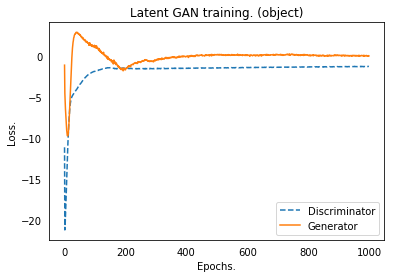

In [5]:
accum_syn_data = []
train_stats = []
n_epochs = 1000
# Train the GAN.
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])
latent_data = PointCloudDataSet(latent_codes)

gan.train(latent_data, params, n_epochs, "./models_checkpoints/", save_gan_model=True, \
          saver_step=saver_step, train_stats=train_stats)

In [6]:
syn_latent_data = gan.generate(10, params["noise_params"])
print(syn_latent_data.shape)

syn_data = []
for vector in syn_latent_data:
    syn_data.append(ae.decode(vector))
    
syn_data = np.asarray(syn_data).reshape((10,2048,3))
print(syn_data.shape)

reconstruct_obj(syn_data)
for i, data in enumerate(syn_data):
    generate_mitsuba_xml(data, class_name + "_gen", i)


(10, 128)
(10, 2048, 3)
Reconstruction item shape: (2048, 3)
Reconstructed


# TODO
### 1. Rewrite CONF Class to fit GANs - DONE
### 2. Implement Discriminator, Generator for the simple LGAN - DONE
### 3. Train
### 4. Try to decode something generated
### 5. Implement Conditional GAN in the LGAN 
### 6. Go to 3 and 4 again